# Project - Day 2 -  Processing DAQ data 💽🗂️📡

## Introduction

Today we will use a simulated DAQ process that will publish messages via NATS with the link to a file that can be downloaded via an HTTP request, as soon as the acquisition machine will store new data. 
You will create a preprocessing program that, upon arrival of a new image, will download it, apply the preprocessing step, and then store it locally in a temporary accumulator.
Once the accumulator is full, it packs the images and upload them back to your Minio server, in a dedicated bucket.

A schematic representation of the data management you are implementing can is reported below
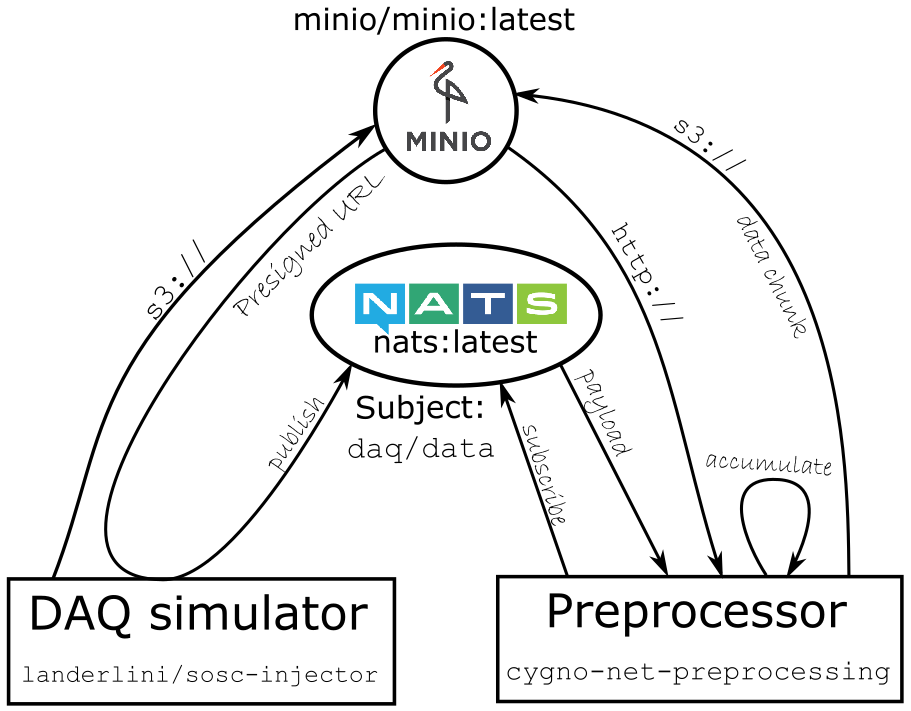

But before diving in those tools, let's make sure we are all aligned at the end of the yesterday session.

### Preprocessing library

To make the preprocessing happen, we had defined a few Python functions that we want to make available as a library to our Python script.

The functions are:
 * `get_energy_keV` 
🏷️, tries to guess the energy of a file from its path (irrelevant for acquired data);
 * `crop_center` ✂️, crops the center of an image with the energy deposit is located;
 * `windowing` 🪟, maps the gray scale code actually used in the image datasets in the range [0, 1] 
 * `get_recoil_type` , 🏷️ tries to guess whether an image is due a nuclear or electromagnetic recoil based on the file path (irrelevant for acquired data).



In [ ]:
import numpy as np
from PIL import Image

import warnings

warnings.filterwarnings('ignore')

def get_energy_keV(filename):
    """
    Return the energy in keV as obtained parsing the file path, as a 
    floating point.
    """
    for token in filename.split("/"):
        if "_keV" in token:
            return float(token[:-4])

def crop_center(np_image, half_win=64):
    """Crop a numpy-represented image around its center, the resulting image will be a square of side 2*half_win"""
    low, high = 576//2 - half_win, 576//2 + half_win
    return np_image[low:high, low:high]

def windowing(np_image, x_min, x_max):
    """Crop a numpy-represented image around its center"""
    return np.clip((np_image - x_min)/(x_max - x_min), 0., 1.)

def get_recoil_type(filename):
    """
    Return the strings "nuclear" or "electronic" if the file is 
    located in a subdir of "NR" or "ER", respectively.
    Return None otherwise.
    """
    if "NR" in filename.split("/"):
        return 'nuclear'
    if "ER" in filename.split("/"):
        return "electronic"
    return None

# Exercise 1 - Check that the DAQ is running ⌛

You DAQ is now running 🚀 isn't it?

Let's check. 

Listen for the topic `daq/data/username`(where username the username that you used for logging in in JupyterHub, it can be also retrieved from the environment variable `JUPYTERHUB_USER`)` with a very simple callback, if you don't hear anything for one minute, well, something in your setup is now working...  🪲
To retrieve environment variable from your python code/notebook: 
```python 
import os 
username = os.environ['JUPYTERHUB_USER'] 
```



A super-simple callback you may use to the purpose is simply printing the received messages, such as 
```python
def callback(msg):
    """Callback function for NATS Client"""
    print (msg.payload)
```


## Exercise 2 - Download a single image via HTTP  ⌛⌛

If you are down here, you have a functioning DAQ involving three services: a simulator, a messaging server based on NATS and a storage server based on Minio! 

Congrats! 👏👏👏

Now it's time to do something of the message injected through NATS. 

The first thing we need is to digest the message and to extract the information it carries, notably:
 * the timestamp of the recorded interaction (the ***metadata***)
 * the acquired image of the interaction (the ***data***)

Now, the NATS `payload` is a raw byte stream, to make it a string we need to agree with the sender on an encoding. Most encoding are equal for the alphanumeric characters, but you might be unable to send nice emojis (and most importanly accented letters) if do not agree on an encoding before starting a communication. 

Maybe luckily, our NATS injector is not interested in submitting emojis 😢, so any encoding is ok, but still you need to choose one. 

Usually people pick `ascii` if they are sure special characters are not there, or `utf-8` if living in a standard Linux world, or `latin-1` if they need to support Windows.


Once you have a string, you can decode it using the `json` module of the Python Standard Libraries, to extract the url and timestamp fields.

The `unpack_payload` function defined here implements these steps for you.


In [ ]:
import json

def unpack_payload (msg):
    """Unpack the payload returning the timestamp and the url, separately."""
    ## Convert the message data in a string, assuming utf-8 encoding
    payload_string = str(msg.payload, 'utf-8')
    ## Convert the payload to a dictionary using the json module
    payload_dict = json.loads(payload_string)
    ## Obtain the url and the timestamp from the dictionary
    url = payload_dict['url']
    timestamp = payload_dict['time']

    ## Return the timestamp and the url
    return timestamp, url
    

You can now plug the `unpack_payload` function in your `callback` and print separately the timestamp and presigned url.

### Download the image via HTTP

Using the `requests` module and its `get` function, obtain the image from the presigned url as returned by `unpack_payload`.

You may want to review:
 * the [function `requests.get`](https://requests.readthedocs.io/en/latest/user/quickstart/)
 * the standard way of managing error codes with the [method `raise_for_status`](https://requests.readthedocs.io/en/latest/api/#requests.Response.raise_for_status)
 * the [`io` module](https://docs.python.org/3/library/io.html) and its [BytesIO](https://docs.python.org/3/library/io.html#io.BytesIO) mimicking file access to memory-located resources
 * the [basics of `pillow`](https://pillow.readthedocs.io/en/stable/reference/Image.html#) and in particular the [function `PIL.Image.open`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open) for loading images from standard formats (such as JPG)


You next cell should look like:

```python
## ... your imports here ...

def download_image(url):
  ## your request
  ## your conversion of the response to PIL.Image 
  return image 
```

### Adapt your `callback` function to display the image instead of its url

Now you have all the pieces to redefine your `callback (msg)` function to download the image from the `url` you unpacked from NATS and to display it in the Jupyter notebook with the `display(image)` function.

Wait for another hit and check your callback is functioning. You should see the 

In [ ]:
## Solution
from pynats import NATSClient

def callback(msg):
    """Callback function from NATS Client"""
    timestamp, url = unpack_payload(msg)
    img = download_image (url)
    display(img)

with NATSClient(NATS_SERVER) as client:
    client.subscribe(subject=subject, callback=callback)
    
    client.wait(count=1)

## Exercise 3 - Download and Upload to your Minio  ⌛⌛⌛⌛

Well done! You are downloading data based on the messages obtained from NATS.

Now you have to walk the opposite path and upload some processed file to Minio.

As you have learned during the morning sessions, **object storage is great for large files accessed as a whole**. Using object storage for a myriad of tiny  images is not exactly what it was designed for.

A step towards improvement is to aggregate the images in chunks or batches and then re-upload the datasets to Minio in one go.

There are better and more robust ways of implementing such an aggregation, but here we try to be minimal to focus on data management aspects, so:
 * define two global vatiables as empty lists, one will accumulate the received images, one will accumulate the timestamps
 * define a function taking as a input the decoded `PIL.Image` and its associated timestamp; converting them to numpy data formats; and appending to them to their lists

> **Important!** 📆 To store the datetime in numpy, use [`numpy.datetime64` data format](https://numpy.org/doc/stable/reference/arrays.datetime.html).

For example
```python
## define global lists
list_of_images = list()
## same for timestamps

def convert_and_accumulate_to_global_lists(timestamp, image):
  np_image = ## convert image to numpy array
  list_of_images.append ( np_image )
  ## same thing for the timestamps
```



In [ ]:
## Solution

list_of_images = []
list_of_timestamps = []

def convert_and_accumulate_to_global_lists(timestamp, image):
    """Accumulate the downloaded images and timestamps to global lists."""
    list_of_images.append(np.asarray(image))
    list_of_timestamps.append(np.datetime64(timestamp))
    

### Upload to Minio the lists

Define another function, say `upload_global_lists_to_minio` taking as an input:
 * a maximal number `n_items` of events to pack and upload
 * the url of the `minio_server`
 * the user name `minio_user` of the Minio server
 * the password `minio_password` of the Minio server
 * the name of the bucket, `minio_bucket`, where to store the aggregated datasets

When invoked, this function will:
 1. Check whether the number of enqueued images (or timestamps) is above the threshold and returns without doing anything else, otherwise.
 2. Pack the global lists, `list_of_images` and `list_of_timestamps` into two arrays and store them to a temporary file using the [function `np.savez`](https://numpy.org/doc/stable/reference/generated/numpy.savez.html).
 3. Establish a connection to Minio based on the url and credentials passed as arguments
 4. Upload the file temporary file with `minio.fput_object` using a filename containing the first or the latest timestamp (enabling name-based ordering).
 5. Clear the global lists (have a look to the [function `list.clear`](https://docs.python.org/3/tutorial/datastructures.html#more-on-lists)).

> **Hint.** The object name might be defined for example as
> ```python
>     object_name = f'data-chunk-{list_of_timestamps[-1]}.npz'
> ```

In [ ]:
import boto3


def upload_global_lists_to_minio(
        minio_folder = "cygno-store",
        n_items=10,
        minio_server="https://minio.131.154.99.220.myip.cloud.infn.it",
        minio_user=username,
        minio_akey=password,
    ):
    """If the accumulation lists are longer than n_items, packs them in a zip file and upload it Minio"""
    if len(list_of_images) < n_items:
        return 
        
    ## Ensure the bucket exists
    s3 = boto3.resource(
        's3',
        endpoint_url=minio_server,
        aws_access_key_id=minio_user,
        aws_secret_access_key=minio_akey
    )

    ## Packs the items to a temporary file
    np.savez("/tmp/cygno.npz",
        image=np.array(list_of_images),
        tstamp=np.array(list_of_timestamps),
    )
        
    ## Upload to minio the temporary file
    object_name = f'{minio_folder}/data-chunk-{list_of_timestamps[-1]}.npz'

    with open('/tmp/cygno.npz', 'rb') as data:
        s3.Bucket(username).put_object(Key=object_name, Body=data)
    print (f"Uploaded {object_name}")  ## <<-- debugging 
        
    ## Reinitialize the accumulation lists
    list_of_images.clear()
    list_of_timestamps.clear()



Then update your callback to execute the functions `convert_and_accumulate_to_global_lists` and `upload_global_lists_to_minio`
and test it with `n_test=3`.

> **Hint!** Clearly, you will need to wait at least for `n_test` hits before seeing the upload part running. Consider using a small `n_test` for debugging purpose.

### Test it

You can use the following function to list the objects in your bucket and check the size and the datatype of the data chunks.




## Exercise 4 - Include the preprocessing step (writing to a different bucket!) ⌛⌛

Define a `preprocessing_step(img)` taking the downloaded `PIL.Image` object as an input and returning a numpy object as obtained applying the *windowing* and *cropping* steps.

> **Hint.** You did something ***very*** similar yesterday. You may want to give a second look to the solutions at the top of this notebook.

### Edit and test the `callback` including the `preprocessing_step`

Starting from your previously defined callback, introduce the preprocessing step as needed. 

The complete flow will be:
 1. `unpack_payload` retrieves the timestamp and the url, separately;
 2. you download the image from its url;
 3. you preprocess the image;
 4. you call `convert_and_accumulate_to_global_lists` to process the single image;
 5. you (maybe) upload the chunk if sufficienly large.

 
> 🚨 **Important!** 🚨
>
> Make sure you ***change the bucket used as destination*** or you'll mix
> preprocessed and raw images in the same bucket.


You may want to use the function `check_latest_uploads` discussed above to ensure that your chunk is actually uploaded to Minio and it has expected datatype and shape.

In [ ]:
check_latest_uploads()

## Conclusion

Today we discussed the concepts of orchestration and data management. 
We have seen how different containers can exchange information through the network relying on third-party applications such as NATS or Minio. 

We have seen how different protocols, such as s3, nats and http can cooperate in a single application to serve different purposes. 

Finally, we have deployed the preprocessing step defined yesterday replacing direct access to the local volumes, with network access to Minio, mediated by NATS for distributing messages.

Now let's include more images in our buckets for the next days, specifying 100 round of 200 in the count bucket

In [ ]:
with NATSClient(NATS_SERVER) as client:
    client.subscribe(subject=subject, callback=callback)
    for _ in range(100):
        client.wait(count=200)